In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import IPython.display as ipd
from ipynb.fs.defs.utility import *
from dataclasses import dataclass

In [126]:
# min frequency of each oscillator
VCO_F_MIN, VCO_F_MAX = 20, 20000
LFO_F_MIN, LFO_F_MAX = 1/60, 1000

WAVE_SIN, WAVE_TRI, WAVE_SQR, WAVE_SAW  = 0, 1, 2, 3 # wavetable shape indices
weight = []

# wavetable

In [127]:
class Wavetable:

    def __init__(self, table_size=2048, max_harmonics=1024, harmonic_derating=1):
        
        self.table_size = table_size

        t = np.linspace(0, 1, table_size, endpoint=False)
        x = 2*np.pi*t
        
        
        # specifies max frequency of each wavetable
        boundaries = [20 * 2**i for i in range(11)]
        boundaries.extend([1.5*b for b in boundaries])
        boundaries.sort()
        self.boundaries = boundaries
        num_BL_tables_per_shape = len(boundaries)
        self.num_BL_tables_per_shape = num_BL_tables_per_shape
                
        # set the maximum number of harmonics for a given octave
        # max number of harmonics per table derated by factor of 1/harmonic_derating
        num_harmonics_per_table = [clamp(int(24000/f/harmonic_derating), 1, max_harmonics) for f in boundaries]

        # allocate empty arrays for the wavetables
        wavetable = []
        sine_samples, tri_samples, saw_samples, square_samples = ([] for _ in range(4))
        
        # generate a band-limited wavetables
        for i in range(num_BL_tables_per_shape):
            
            # add the first harmonic to each wave type
            sine_samples.append(np.sin(x))
            w_tri = w_saw = w_square = np.sin(x)
            
            # zero out the phase increments
            tri_offs = saw_offs = square_offs = 0
            
            # process harmonics higher than the first
            for k in range(2, num_harmonics_per_table[i]+1):
                if k % 2 != 0: # only odd harmonics
                    # tri
                    tri_offs += np.pi
                    new_wave_tri = (1/(k*k)) * np.sin(x*k + tri_offs)
                    w_tri = [a + b for a, b in zip(w_tri, new_wave_tri)]

                    # square
                    new_wave_square = (1/k) * np.sin(x*k)
                    w_square = [a + b for a, b in zip(w_square, new_wave_square)]

                # saw
                saw_offs += np.pi
                new_wave_saw = (1/k) * np.sin(x*k + saw_offs)
                w_saw = [a + b for a, b in zip(w_saw, new_wave_saw)]


            tri_samples.append(normalize(w_tri))
            square_samples.append(normalize(w_square))
            saw_samples.append(normalize(w_saw))

        wavetable.append(sine_samples) # sine
        wavetable.append(tri_samples) # triangle
        wavetable.append(square_samples) # square
        wavetable.append(saw_samples) # saw    
        
        self.num_waves = len(wavetable)

        wavetable = list(np.concatenate(wavetable).flat)

        self.wavetable = wavetable
        
    def get_num_waves(self):
        return self.num_waves
    
    def get_table_size(self):
        return self.table_size
    
    def get_num_BL_tables_per_shape(self):
        return self.num_BL_tables_per_shape
    
    def get_wavetable(self):
        return self.wavetable
    
    def get_table_for_shape(self, wave_shape):
        table_size = self.table_size * self.num_BL_tables_per_shape
        start_idx = wave_shape * table_size
        return self.wavetable[start_idx:start_idx+table_size]
    
    def get_wave_cycle(self, wave_shape, table_idx=0):
        table_size = self.table_size * self.num_BL_tables_per_shape
        wave_shape_start_idx = wave_shape * table_size
        start_idx = wave_shape_start_idx + table_idx*self.table_size
        return self.wavetable[start_idx:start_idx+self.table_size]
        
    def lookup(self, wave_shape, octave_idx, sample_idx):
        i,j,k = wave_shape, octave_idx, sample_idx
        idx = self.table_size*((self.num_BL_tables_per_shape*i)+j) + k
        if idx >= len(self.wavetable):
            print(i, j, k)
        return self.wavetable[idx]


    # returns a sample from the wave table for wave with frequency f and wavetable index sample_idx
    # - sample_idx in range [0, TABLE_SIZE]
    def sample(self, wave_shape, f, sample_idx):
        '''
        algorithm:
        1. pick the wave shape that lower bounds the shape CV
        2. select the BL table for the desired pitch
        3. sample the BL table using lin interpolation
        4. repeat above steps on the shape that upper bounds the shape CV
        5. morph between two samples based on waveshape CV 
        '''
        if sample_idx >= self.table_size:
            print(sample_idx)
            
        # clamp the inputs
        wave_shape = clamp(wave_shape, 0, self.num_waves-1)
        f = clamp(f, LFO_F_MIN, VCO_F_MAX)
        
        # wavetable only defined at integer waveshape indices
        wave_shape_int = int(wave_shape)

        i = y1 = y2 = 0            
        while i < 2:
            if wave_shape_int > self.num_waves-1:
                y2 = y1
                break
            
            # compute index of band-limited wavetable for the input frequency
            table_idx = 0
            while table_idx < len(self.boundaries)-1:
                if f < self.boundaries[table_idx]:
                    break
                table_idx += 1
                
            # compute integer sample indices that surround sample_idx
            x0 = int(sample_idx)
            x1 = (x0 + 1) % self.table_size

            # sample the BL table using linear interpolation
            samp_for_x0 = self.lookup(wave_shape_int, table_idx, x0)
            samp_for_x1 = self.lookup(wave_shape_int, table_idx, x1)
            y = lerp2d(x0, samp_for_x0, x1, samp_for_x1, sample_idx)
                        
            if i == 0:
                y1 = y
            else:
                y2 = y
                
            wave_shape_int += 1
            i += 1
            
        y = lerp1d(y1, y2, wave_shape % 1)

        return y

# CV

In [165]:
CV_CH_WAVESHAPE = 0
CV_CH_MODE = 1
CV_CH_COARSE_ADJ = 2
CV_CH_FINE_ADJ = 3
CV_CH_VPO = 4
CV_CH_FM_EXP = 5

# specifies human-readable name for CV channel
channel_idx_alias = {
    'waveshape': CV_CH_WAVESHAPE,
    'mode': CV_CH_MODE,
    'coarse_adj': CV_CH_COARSE_ADJ,
    'fine_adj': CV_CH_FINE_ADJ,
    'vpo': CV_CH_VPO,
    'fm_exp': CV_CH_FM_EXP,
}

# specifies the raw value ranges for each CV channel
ranges = {
    CV_CH_WAVESHAPE: (0,1),
    CV_CH_MODE: (0,1),
    CV_CH_COARSE_ADJ: (0,1),
    CV_CH_FINE_ADJ: (0,1),
    CV_CH_VPO: (-5,5),
    CV_CH_FM_EXP: (-5,5)
}

class CV:
    ### a CV input belonging to a specified channel ###
    ### the input and input range are specified ###
    ### the input is normalized to the range [0,1] ###
    
    def __init__(self, channel, raw_val):
        self.channel = channel
        self.range_min, self.range_max = ranges[channel]
        self.raw_val = raw_val
        self.normalized_val = translate_range(raw_val, self.range_min, self.range_max, 0, 1)
        
    def get_raw(self):
        return self.raw_val
    
    def get_normalized(self):
        return self.normalized_val

class CV_stream:
    ### a stream of CV values ###
    
    def __init__(self, channel, stream_list):
        self.stream = [CV(channel, val) for val in stream_list]

    def get(self, i):
        if i < 0 or i >= len(self.stream):
            return 0
        return self.stream[i]

class CV_stream_collection:
    ### a collection of CV streams ###
    
    def __init__(self):
        self.cv_collection = []
        
    def add_stream(self, stream):
        self.cv_collection.append(stream)
        
    def get_snapshot_at(self, i):
        return CV_snapshot([stream.get(i) for stream in self.cv_collection])

@dataclass
class CV_snapshot:
    ### represents a snapshot in time of CV values across all channels in a collection ###
    
    cv_values: [CV]
        
    def get_channel(self, channel):
        if channel < 0 or channel >= len(self.cv_values):
            return 0
        return self.cv_values[channel]

class CV_sim:
    ### a module that generates simulated CV inputs for a specified duration ###
    
    def __init__(self, init_dur=3, init_dict=None, Fs=48000):
        self.init_dur = init_dur
        self.init_dict = init_dict
        self.Fs = Fs
        self.set_dur(init_dur)
        
    def set(self, ch, inp):
        self.test_dict[ch] = inp
        
    def reset(self):        
        if self.init_dict:
            self.test_dict = self.init_dict
        else:
            self.test_dict = {
                'waveshape': self.const_inp(WAVE_SAW),
                'mode': self.const_inp(0),
                'coarse_adj': self.const_inp(0.445), # 437 Hz
                'fine_adj': self.const_inp(0),
                'vpo': self.const_inp(0),
                'fm_exp': self.const_inp(0),
            }
        
    def set_dur(self, dur):
        self.dur = dur
        self.N = self.Fs * dur
        self.reset()
        
    def const_inp(self, val):            
        return [val] * self.N
        
    def ramp_inp(self, from_val, to_val):
        return np.linspace(from_val, to_val, self.N)

    def sin_inp(self, A, f):
        t = np.linspace(0, self.dur, self.N)
        return A*np.sin(2*np.pi*t*f)

# playback

In [166]:
class Playback:
    
    def __init__(self, Fs=48000):
        self.Fs = Fs

    def get_Fs(self):
        return self.Fs

    def play(self, wavetable, cvsim, show_progress=False, listen=True, plot=True, sg_fmin=0, sg_fmax=24000):
        
        # parse the cvsim input
        cv_col = CV_stream_collection()
        for k in cvsim.test_dict.keys():
            ch = channel_idx_alias[k]
            cv_col.add_stream(CV_stream(ch, cvsim.test_dict[k]))

        # create N samples
        table_size = wavetable.get_table_size()
        output = []
        sample_idx = 0
        for i in range(cvsim.N):

            # get the cv for this sample
            cv_ss = cv_col.get_snapshot_at(i)
            
            # extract the cv for each channel
            waveshape = cv_ss.get_channel(CV_CH_WAVESHAPE)
            mode = cv_ss.get_channel(CV_CH_MODE)
            coarse_adj = cv_ss.get_channel(CV_CH_COARSE_ADJ)
            fine_adj = cv_ss.get_channel(CV_CH_FINE_ADJ)
            vpo = cv_ss.get_channel(CV_CH_VPO)
            fm_exp = cv_ss.get_channel(CV_CH_FM_EXP)

            # determine the frequency based on the CV
            if mode.get_raw() == 0:
                coarse_translated = translate_range(coarse_adj.get_normalized(), coarse_adj.range_min, coarse_adj.range_max, 0, 10)
                f = VCO_F_MIN * (2**coarse_translated)
                volt_from_vpo = vpo.get_raw()
                f *= 2**volt_from_vpo
                volt_from_fm = fm_exp.get_raw()
                f *= 2**volt_from_fm

                # clamp the frequency to within allowable range
                f = clamp(f, VCO_F_MIN, VCO_F_MAX)
            elif mode.get_raw() == 1:
                f = translate_range(coarse_adj.get_normalized(), coarse_adj.range_min, coarse_adj.range_max, LFO_F_MIN, LFO_F_MAX)
            
            # sample the wavetable
            y = wavetable.sample(waveshape.get_raw(), f, sample_idx)
            output.append(y)   

            # update the (decimal) index in the wavetable
            sample_idx += table_size * f/self.Fs # adjust the playback rate
            sample_idx %= table_size # keep sample_idx in wavetable index range

            # progress indication
            if show_progress:
                prog = 100*i/cvsim.N
                if prog % 10 == 0:
                    print(prog, "%")                    

        wave = np.array(output)
        
        # create output audio and plot
        if listen:
            display(ipd.Audio(wave, rate=self.Fs))
        if plot:
            fig = plt.figure()
            ax = fig.add_subplot()
            ax.set_ylabel('frequency (Hz)')
            ax.set_xlabel('time (s)')
            plt.specgram(wave, Fs=48000, NFFT=500);
            plt.axis([0, cvsim.dur, sg_fmin, sg_fmax])
            plt.show()

        return wave

# examples

In [167]:
# create wavetables, one rich in harmonics, one not
wavetable = Wavetable()
wavetable_poor = Wavetable(harmonic_derating=10)

# set cvsim
cvsim = CV_sim()

# create the playback task
pb = Playback()

## constant frequency

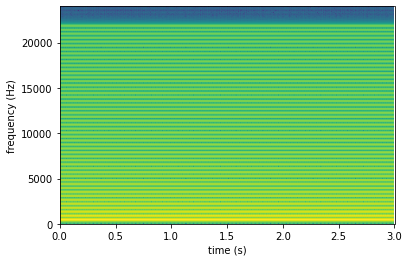

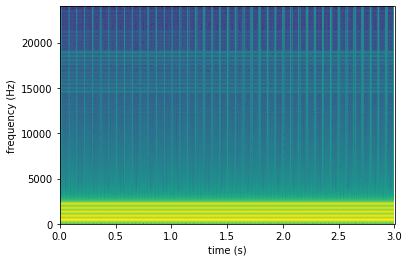

In [168]:
cvsim.reset()
cvsim.set('waveshape', cvsim.const_inp(WAVE_SAW))
pb.play(wavetable, cvsim, plot=True);
pb.play(wavetable_poor, cvsim);

## frequency sweep

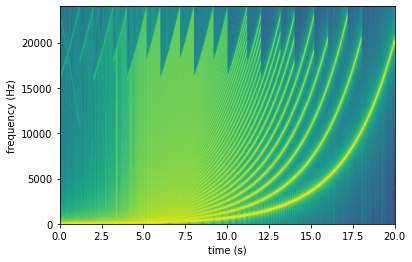

In [173]:
cvsim.reset()
cvsim.set_dur(20)
cvsim.set('waveshape', cvsim.const_inp(WAVE_SAW))
cvsim.set('coarse_adj', cvsim.ramp_inp(0, 1))
pb.play(wavetable, cvsim, sg_fmin=0, sg_fmax=24000);

## ramp one volt/octave at constant coarse

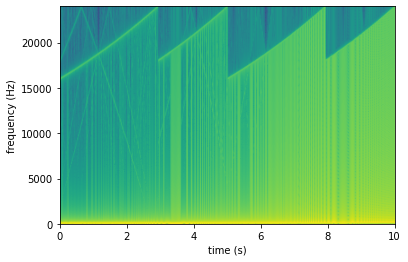

In [172]:
cvsim.reset()
cvsim.set('coarse_adj', cvsim.const_inp(0.1))
cvsim.set('vpo', cvsim.ramp_inp(0, 2))
pb.play(wavetable, cvsim);

## sinusoidal one volt/octave at wavetable boundary

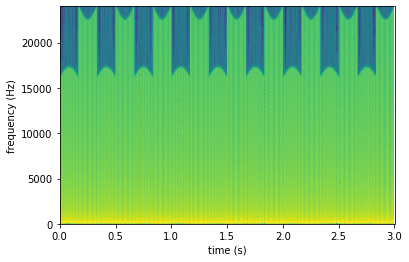

In [149]:
cvsim.reset()
cvsim.set('coarse_adj', cvsim.const_inp(0.3))
cvsim.set('vpo', cvsim.sin_inp(A=0.1, f=3))
pb.play(wavetable, cvsim);

## expo FM at constant coarse

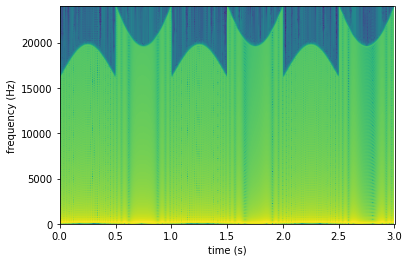

In [150]:
cvsim.reset()
cvsim.set('coarse_adj', cvsim.const_inp(0.3))
cvsim.set('fm_exp', cvsim.sin_inp(A=0.3, f=1))
pb.play(wavetable, cvsim);

## expo FM on ramping pitch

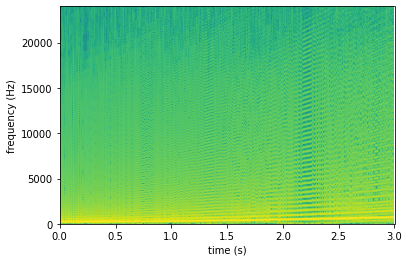

In [144]:
cvsim.reset()
cvsim.set('coarse_adj', cvsim.ramp_inp(0.3, 0.5))
cvsim.set('fm_exp', cvsim.sin_inp(A=1, f=1000))
pb.play(wavetable, cvsim);

## wave shape morphing

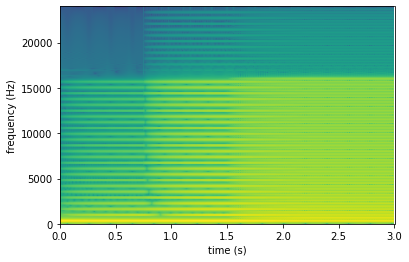

In [145]:
cvsim.reset()
cvsim.set('waveshape', cvsim.ramp_inp(0, wavetable.get_num_waves()))
cvsim.set('coarse_adj', cvsim.const_inp(0.4))
pb.play(wavetable, cvsim);

## table size = 2048 vs 256

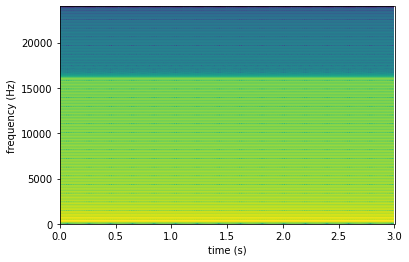

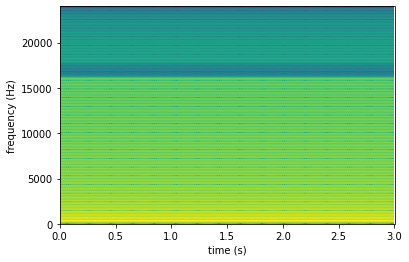

In [146]:
wavetable_256 = Wavetable(table_size=256)
cvsim.reset()
cvsim.set('coarse_adj', cvsim.const_inp(0.4))
pb.play(wavetable, cvsim);
pb.play(wavetable_256, cvsim);

## LFO

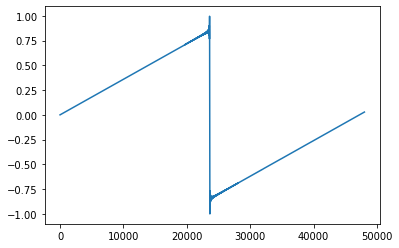

In [147]:
cvsim.reset()
cvsim.set_dur(10)
cvsim.set('waveshape', cvsim.const_inp(WAVE_SAW))
cvsim.set('mode', cvsim.const_inp(1))
cvsim.set('coarse_adj', cvsim.const_inp(0.001)) # 0.001 = 1 Hz
out = pb.play(wavetable, cvsim, sg_fmax=1000, plot=False);
plt.figure()
plt.plot(out[0:48000])